In [1]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Dataset

In [24]:
data = pd.read_csv('data/aug_train.csv')
data.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

The dataset contains 19158 records with most features being categorical

In [26]:
data.drop(columns='enrollee_id', inplace=True)
X = data.drop('target', axis=1)
y = data['target']

In [27]:
test_idx = data.dropna().sample(1000, random_state=42).index

In [28]:
# check missingness of features
data.isnull().sum()/data.shape[0]

city                      0.000000
city_development_index    0.000000
gender                    0.235306
relevent_experience       0.000000
enrolled_university       0.020148
education_level           0.024011
major_discipline          0.146832
experience                0.003393
company_size              0.309949
company_type              0.320493
last_new_job              0.022080
training_hours            0.000000
target                    0.000000
dtype: float64

In [29]:
missing_cols = X.columns[X.isnull().sum()/X.shape[0] > 0]

X[missing_cols].head()

,gender,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job
0,Male,no_enrollment,Graduate,STEM,>20,NaN,NaN,1
1,Male,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4
2,NaN,Full time course,Graduate,STEM,5,NaN,NaN,never
3,NaN,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never
4,Male,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4


Missing features in the dataset are all categorical

In [30]:
# scale numerical features
scaler = StandardScaler()
num_cols = [c for c in X.columns if X[c].dtype != 'object']
for col in num_cols:
    X[col] = scaler.fit_transform(X[[col]])

In [31]:
def encode_notnull(encoder, col):
    col_notnull = col[col.notnull()].copy()
    col_encoded = encoder.fit_transform(col_notnull)
    col.loc[col.notnull()] = col_encoded
    return col

# encode non-null nominal features
enc = LabelEncoder()
nominal_cols = ['city', 'gender', 'relevent_experience', 'major_discipline', 'company_type']
for col in nominal_cols:
    X[col] = encode_notnull(enc, X[col])

# encode non-null ordinal features 
enrolled_university_ord = {
    'no_enrollment': 0,
    'Part time course': 1,
    'Full time course': 2
}

education_level_ord = {
    'Primary School': 0,
    'High School': 1,
    'Graduate': 2,
    'Masters': 3,
    'Phd': 4
}

experience_ord = {
    '<1': 0,
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5,
    '6': 6,
    '7': 7,
    '8': 8,
    '9': 9,
    '10': 10,
    '11': 11,
    '12': 12,
    '13': 13,
    '14': 14,
    '15': 15,
    '16': 16,
    '17': 17,
    '18': 18,
    '19': 19,
    '20': 20,
    '>20': 21
}

company_size_ord = {
    '50-99': 2,
    '100-500': 3,
    '10000+': 7,
    '10/49': 1,
    '1000-4999': 5,
    '<10': 0,
    '500-999': 4,
    '5000-9999': 6
}

last_new_job_ord = {
   '1': 1,
    '>4': 5,
   '2': 2,
   'never': 0,
   '4': 4,
   '3': 3,
}

X['enrolled_university'] = X['enrolled_university'].map(enrolled_university_ord)
X['education_level'] = X['education_level'].map(education_level_ord)
X['experience'] = X['experience'].map(experience_ord)
X['company_size'] = X['company_size'].map(company_size_ord)
X['last_new_job'] = X['last_new_job'].map(last_new_job_ord)

/var/folders/gt/s4052ywd2_lfwczqzy11cj_80000gp/T/ipykernel_1703/628547138.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col.loc[col.notnull()] = col_encoded


# Simple dropping of rows with missing data

In [32]:
X_dropna = X.dropna()
y_dropna = y.loc[X_dropna.index]

X_valid = X.loc[test_idx]
y_valid = y.loc[test_idx]
X_train = X_dropna[~X_dropna.index.isin(X_valid.index)]
y_train = y_dropna[~y_dropna.index.isin(test_idx)]

print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_valid:', X_valid.shape)
print('y_valid:', y_valid.shape)


X_train: (7955, 12)
y_train: (7955,)
X_valid: (1000, 12)
y_valid: (1000,)


accuracy: 0.856
f1 score: 0.3628318584070796


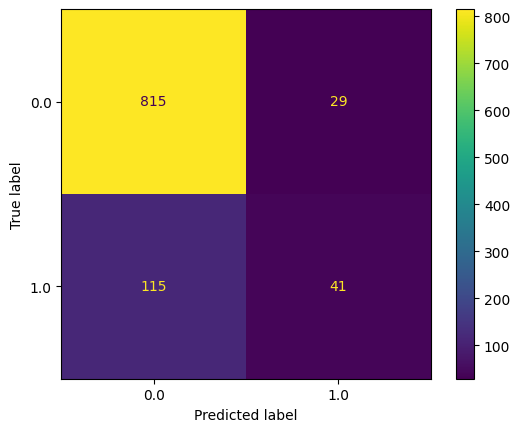

In [33]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_valid)
print('accuracy:', accuracy_score(y_valid, y_pred))
print('f1 score:', f1_score(y_valid, y_pred))
cm = confusion_matrix(y_valid, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

# KNN Imputation

In [34]:
# impute missing values using KNN
knn = KNNImputer(n_neighbors=1)

X_complete = pd.DataFrame(knn.fit_transform(X), columns=X.columns)

In [36]:
X_valid = X_complete.loc[test_idx]
y_valid = y.loc[test_idx]
X_train = X_complete[~X_complete.index.isin(X_valid.index)]
y_train = y[~y.index.isin(test_idx)]

print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_valid:', X_valid.shape)
print('y_valid:', y_valid.shape)

X_train: (18158, 12)
y_train: (18158,)
X_valid: (1000, 12)
y_valid: (1000,)


accuracy: 0.854
f1 score: 0.3113207547169811


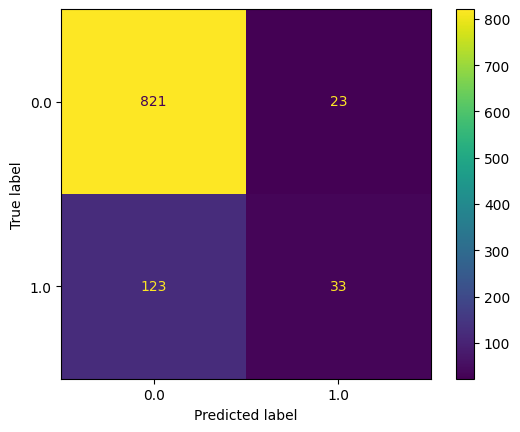

In [37]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_valid)
print('accuracy:', accuracy_score(y_valid, y_pred))
print('f1 score:', f1_score(y_valid, y_pred))
cm = confusion_matrix(y_valid, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

# Mode imputation

# Training the model using the best imputation strategy

In [181]:
# split into train and valid sets
X_train, X_valid, y_train, y_valid = train_test_split(
    X_complete, y, test_size=0.2, random_state=42
)

In [128]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [129]:
y_pred = clf.predict(X_valid)

In [130]:
accuracy_score(y_valid, y_pred)

0.7638308977035491